In [67]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

### Get the Data

In [122]:
data = yf.download("AAPL", start='2018-01-01',  interval="1d") 
data.columns = data.columns.get_level_values(0)
data.index = pd.to_datetime((data.index).tz_localize(None))
print(data.shape)
data.tail()

[*********************100%***********************]  1 of 1 completed

(1741, 6)


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-11-25,232.869995,232.869995,233.250000,229.740005,231.460007,90152800
2024-11-26,235.059998,235.059998,235.570007,233.330002,233.330002,45986200
2024-11-27,234.929993,234.929993,235.690002,233.809998,234.470001,33498400
2024-11-29,237.330002,237.330002,237.809998,233.970001,234.809998,28481400
2024-12-02,239.589996,239.589996,240.789993,237.160004,237.270004,41321136


#### Purging observation in the training set

In [104]:
def getTrainTimes(t1, testTimes):
    '''
    Given testTimes, find the times of the training observations.
    -t1.index: Time when the observation started.
    -t1.value: Time when the observation ended.
    -testTimes: Times of testing observations.
    '''
    trn = t1.copy(deep=True)
    for i, j in testTimes.items():
        df0 = trn[(i<= trn.index)&(trn.index<=j)].index # train starts within test
        df1 = trn[(i<=trn)&(j>=trn)].index # train ends within test
        df2 = trn[(trn.index<=i)&(j<=trn)].index # train envelops test
        trn = trn.drop(df0.union(df1).union(df2))
    return trn

In [123]:
data['Date_shift3'] = data.index.to_series().shift(-50)

In [124]:
test_times_idx = data.index[(data.index>='2022-01-01')&(data.index<='2022-12-31')]
test_times = data.loc[test_times_idx]['Date_shift3']
train_times = data.drop(test_times_idx)['Date_shift3']

In [125]:
train_times_purged = getTrainTimes(train_times, test_times)

In [132]:
time1 = max(train_times_purged.index[train_times_purged.index<min(test_times.index)])
time2 = min(test_times.index)
time3 = max(test_times.index)
time4 = min(train_times_purged.index[train_times_purged.index>max(test_times.index)])
print(time1)
print(time2)
print(time3)
print(time4)

2021-10-20 00:00:00
2022-01-03 00:00:00
2022-12-30 00:00:00
2023-03-16 00:00:00


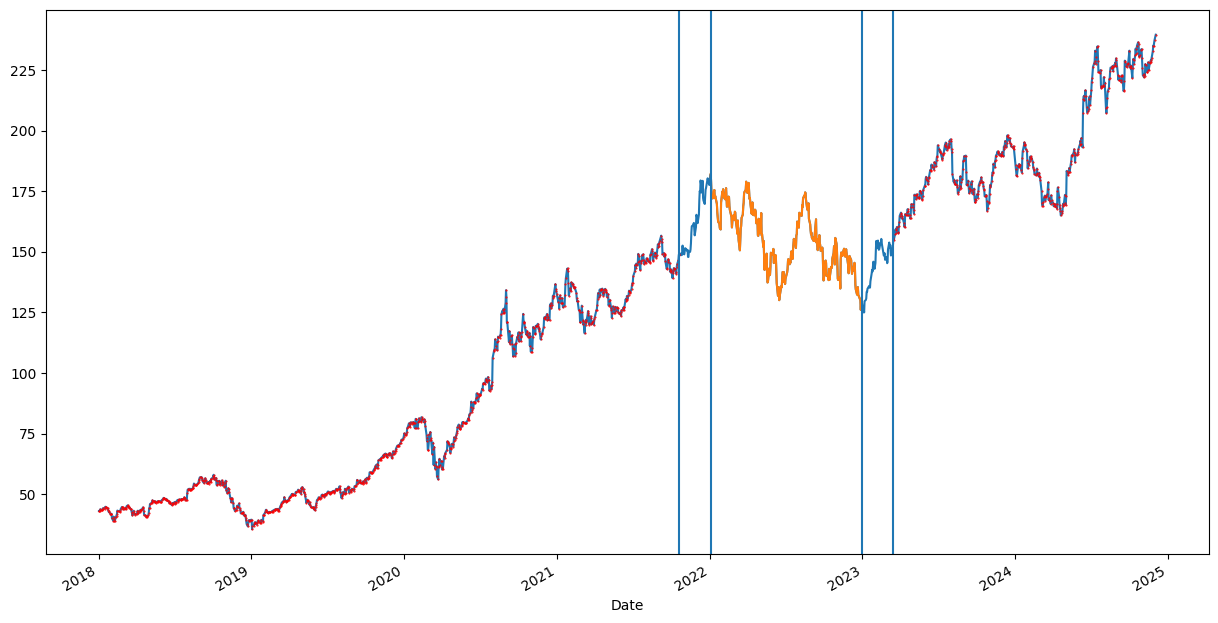

In [136]:
data['Close'].plot(figsize=(15,8))
data.loc[test_times.index]['Close'].plot()
data.loc[train_times_purged.index]['Close'].plot(style='.', color='r', ms=1)
plt.axvline(x=time1)
plt.axvline(x=time2)
plt.axvline(x=time3)
plt.axvline(x=time4)
plt.show()

### Embargo on training observations

In [2]:
def getEmbargoTimes(times, pctEmbargo):
    # Get embargo time for each bar
    step = int(times.shape[0]*pctEmbargo)
    if step == 0:
        mbrg = pd.Series(times, index=times)
    else:
        mbrg = pd.Series(times[step:], index=times[:-step])
        mbrg = mbrg.append(pd.Series(times[-1], index=times[-step:]))
    return mbrg

In [ ]:
testTimes = pd.Series(mbrg[dt1], index=[dt0]) # include embargo before purge
trainTimes = getTrainTimes(t1, testTimes)
testTimes = t1.loc[dt0: dt1]